# **<center> `Note`: Move Notebook to `scripts` folder**

## **DineMate Foodbot**

DineMate is an AI-powered restaurant assistant that handles food orders efficiently. It uses LangGraph
for state management, LangChain for LLM integration, and SQLite for storing orders. This script provides
a CLI interface for users to interact with the bot, view the menu, place orders, and track orders.

## **Features**
- Fetches and displays the restaurant menu.
- Processes user orders, calculates totals, and saves them to a database.
- Supports order modification/cancellation within 10 minutes.
- Provides polite and emoji-enhanced responses for a user-friendly experience.

## **Dependencies**
- `langchain_groq`: For LLM integration with Grok.
- `langgraph`: For state management and workflow orchestration.
- `sqlite3`: For database operations.
- `python-dotenv`: For environment variable management.
- `utils`: Custom module for LLM configuration (assumed to exist).
- `SQLLITE_db`: Custom module for database operations (assumed to exist).

## **Setup**
1. Ensure all dependencies are installed: `pip install langchain-groq langgraph python-dotenv`.
2. Create a `.env` file with your LLM API key (e.g., `GROQ_API_KEY=your_key`).
3. Ensure `utils.py` and `SQLLITE_db.py` are available in the same directory.

## **Usage**
Run the script: `python foodbot.py`
- Type commands like "show menu", "order 1 pepsi", or "confirm order".
- Type "exit" or "quit" to stop the program.

In [1]:
import warnings, json
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from streaming import StreamHandler, stream_graph_updates
from pprint import pprint
from IPython.display import display, Markdown, Image
from graph import build_graph
from utils import configure_llm
from prompt import SUMMARIZE_PROMPT
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage, RemoveMessage
from tools import *
from config import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load environment variables
load_dotenv()

# Initialize memory for state persistence
memory = MemorySaver()

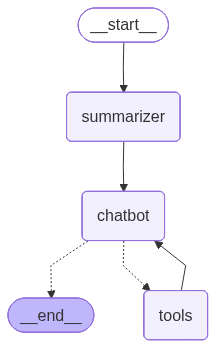

In [3]:
graphs = build_graph()
display(Image(graphs.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
menu = await get_full_menu()
pprint(json.loads(menu))

In [ ]:
await check_order_status('353')

'Status: Pending, Delivery: 01:41 PM (delayed ~247784 min)'

In [ ]:
await cancel_order('345')

'Cannot cancel: past 10-min window.'

In [ ]:
llm = configure_llm(model_name="openai/gpt-oss-120b", force_reload=True)
llm.invoke("Hello").content

'Hello! How can I assist you today?'

In [ ]:
config1 = { 'configurable': { 'thread_id': '1'} }
user_input = "Hello"
state = await graphs.ainvoke(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config1
    )
print(state["messages"][-1].content)

Hello! 👋 How can I assist you today?  
- Want to see the menu 📜?  
- Ready to place an order 🍔?  
- Need help with an existing order 💰?  

Anything else I can help with? 😊


In [4]:
# ✅ CLI Chat Loop
config1 = { 'configurable': { 'thread_id': '1'} }
display(Markdown("**🍽️ Welcome to DineMate! Type 'exit' to quit.**\n"))

while True:
    user_input = input("👤 You: ")
    if user_input.lower() in ['exit', 'quit']:
        display(Markdown("**👋 Goodbye! Hope you enjoy your meal!**"))
        break
    
    display(Markdown(f"**👤 You:** {user_input}"))

    state = await graphs.ainvoke(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config1
    )

    reply = state["messages"][-1].content
    display(Markdown(f"**🤖 DineMate:** {reply}"))

**🍽️ Welcome to DineMate! Type 'exit' to quit.**


**👤 You:** hello

**🤖 DineMate:** 👋 Hi there! I'm DineMate, your friendly restaurant assistant. How can I help you today?  

Anything else I can help with? 😊

**👤 You:** i want 10k pepsi for my party

**🤖 DineMate:** 📦 That’s a big order! Just to confirm: you’d like **10,000 Pepsi** bottles for your party? The price per bottle is **$2.49**.  

If that’s correct, I’ll calculate the total and present a summary for you.  

Anything else I can help with? 😊

**👤 You:** what will be total???

**🤖 DineMate:** ✅ Let’s calculate the total for 10,000 Pepsi bottles:

| Item   | Qty  | Unit Price | Subtotal   |
|--------|------|------------|------------|
| Pepsi  | 10,000 | $2.49     | **$24,900** |

**Total: $24,900**

That’s a large order! Would you like me to proceed and place this order for you?  

Anything else I can help with? 😊

**👤 You:** great, book it

**🤖 DineMate:** ✅ Your order has been placed!  
- **Order ID:** 364  
- **Items:** 10,000 Pepsi bottles  
- **Total:** $24,900  
- **Estimated Delivery:** 40 minutes

If you’d like to check the status later or need anything else, just let me know!  

Anything else I can help with? 😊

**👤 You:** 

**🤖 DineMate:** Sure thing! Just let me know if you’d like to:

- Check the status of your order (ID 364)  
- Make a change or cancel  
- Place a new order  

Anything else I can help with? 😊

**👤 You:** 

**🤖 DineMate:** Got it! If you need anything—whether it’s checking your order, making a change, or placing a new one—just give me a shout.  

Anything else I can help with? 😊

**👤 You:** yeah sure, what's the status, how much time it will take??

**🤖 DineMate:** 📦 Your order (ID 364) is currently **Pending**.  
Estimated delivery time: **11:11 AM**.

Let me know if you’d like to modify, cancel, or place another order!  

Anything else I can help with? 😊

**👤 You:** thank you

**🤖 DineMate:** You’re welcome! If you need anything else—another order, a status update, or any questions—just let me know.  

Anything else I can help with? 😊

**👋 Goodbye! Hope you enjoy your meal!**

In [5]:
len(state['messages'])

5

In [9]:
Markdown(state['summary'])

- Confirmed order: Order ID 364, 10,000 Pepsi bottles, total $24,900.  
- Pending: User requested status update and estimated delivery time.

In [23]:
messages_to_summarize = state["messages"][:-4]

In [26]:
content = "\n".join(
        f"{msg.type.upper()}: {msg.content}"
        for msg in messages_to_summarize
        if hasattr(msg, "content") and msg.content.strip()
    )
display(Markdown(content))

HUMAN: i want a pepsi
TOOL: {"Pepsi":2.49}
AI: Great! Here’s your order summary:

| Item  | Qty | Unit Price | Subtotal |
|-------|-----|------------|----------|
| Pepsi | 1   | $2.49      | $2.49    |
**Total: $2.49**

✅ Shall I place this order for you?  

Anything else I can help with? 😊
HUMAN: no
AI: No problem! Let me know whenever you’d like to place an order or need anything else.  

Anything else I can help with? 😊

In [35]:
prompt = [
        SystemMessage(content=SUMMARIZE_PROMPT),
        HumanMessage(content=content + "\n\nSummary:")
    ]

llm = configure_llm()
summzarize = await llm.ainvoke(prompt)

In [39]:
Markdown(summzarize.content.strip())

The user requested a single Pepsi (price $2.49). The chatbot generated an order summary showing 1 × Pepsi for a total of $2.49 and asked whether to place the order. The user responded “no,” indicating they do not wish to proceed at this time. Consequently, the order remains unconfirmed and no order ID has been created. No additional items, preferences, allergies, or special requests were mentioned. The last interaction was the user’s decline to place the order, after which the chatbot acknowledged the decision and offered further assistance.

In [47]:
keep_count = 4
messages_to_delete = state["messages"][:-keep_count]

In [50]:
messages_to_delete[0].id

'1a072c72-b965-497a-8f51-e7e9d74e8ddd'

In [ ]:
messages_to_remove = [RemoveMessage(id=msg.id) for msg in messages_to_delete]

In [52]:
messages_to_remove

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1a072c72-b965-497a-8f51-e7e9d74e8ddd'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='run--3f1febf7-3493-486e-b058-bfca22ab5160-0'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='d1a2c32d-5592-4d1f-b52b-85c0d220b0de'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='run--65019714-916d-4ad6-a365-9db5aa6e5751-0'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='b41f80a7-fe29-4f8b-b32a-147a2b6f0368'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='run--b77e95f2-7610-4ea0-bf87-2b0908110185-0')]

In [14]:
async def stream_graph_updates(user_input, config1):
    async for message_chunk, metadata in graphs.astream(
                    {"messages": [{"role": "user", "content": user_input}]}, config=config1, stream_mode="messages"
                    ):
        
        if isinstance(message_chunk, AIMessage):
            yield message_chunk.content

In [15]:
user_input = "hey"
config1 = { 'configurable': { 'thread_id': '1'} }

async for chunk in stream_graph_updates(user_input, config1):
    print(chunk, end="", flush=True)

Hey there! 👋 What can I do for you today—look at the menu, place an order, or something else?  

Anything else I can help with? 😊